# Does NDx replicate the biology?

In [51]:
import napari
from macrohet import dataio, tile, tools, visualise, colours
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np
from macrohet.notify import send_sys_message as notify
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zarr
import csv

palette = colours.expanded_piyg
sns.set_theme(style = 'white')
sns.set(font='Nimbus Sans', style = 'white')

# Define a function to remove outliers using IQR
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]
    
def calculate_time(row):
    if row['Expt. ID'] == 'PS0000':
        return row['Frame']
    else:
        return row['Frame'] / 2
import ast
# Assuming your DataFrame 'combined_df' looks like this with 'Acq. ID' as a string
# Create a small function to safely convert the string tuple
def parse_tuple(t):
    try:
        # Convert the string that looks like a tuple into an actual tuple
        return ast.literal_eval(t)
    except ValueError:
        # Return None or some form of error handling if conversion fails
        return None

import warnings
import pandas as pd
# Disable the FutureWarning related to use_inf_as_na
warnings.simplefilter(action='ignore', category=FutureWarning)
with pd.option_context('mode.use_inf_as_na', True):
    pass 

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

image_resolution = float('1.4949402023919043E-07') #float(metadata['ImageResolutionX'].iloc[0])
meters_area_per_pixel = image_resolution**2
mum_sq_scale_factor = (1E-6)**2
pixel_to_mum_sq_scale_factor = meters_area_per_pixel/mum_sq_scale_factor

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [5]:
expt_IDs = ['PS0000', 'ND0002', 'ND0003']

### Iterate over each image and find expression of GFP

In [24]:
macrophage_threshold = 250

In [43]:
np.count_nonzero(frame > macrophage_threshold)

15866774

In [42]:
np.sum(frame)

26494278199

In [ ]:

for expt_ID in tqdm(expt_IDs):
    if expt_ID != 'ND0002':
        continue
    if expt_ID == 'PS0000':
        gfp_channel = 0
    else:
        gfp_channel = 1
    
    # se experiment dir
    base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
    # point to images 
    image_dir = os.path.join(base_dir, 'acquisition/zarr')
    # set output dir
    output_dir = os.path.join(base_dir, 'results/whole_fov_macrophage_growth/raw_data')
    os.makedirs(output_dir, exist_ok=True)
    # load metadata
    metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
    assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
    # initiate empty rfp_df
    rfp_df = pd.DataFrame({}, columns = assay_layout.index)
    for acq_ID, data in tqdm(assay_layout.iterrows(), total = len(assay_layout), desc = f'Iterating over positions in {expt_ID}', leave = False):
        # if os.path.exists(os.path.join(output_dir, f'GFP_signals_{acq_ID}.{expt_ID}.csv')):
        #     continue

        try:

            strain = data['Strain']
            compound = data['Compound']
            conc = data['Concentration']
            name = f'{strain, compound, conc}'
            row, column = acq_ID
            # load images
            image_fn = f'{image_dir}/{row, column}.zarr'
            images_zarr = zarr.open(image_fn, mode='r') 
            
            gfp_images = images_zarr.images[:,gfp_channel,...]
            gfp_images = np.max(gfp_images, axis = 1)
            
            gfp_signals = []
            for t in tqdm(range(0,len(gfp_images)), leave = False, desc = f'Iterating over frames in {acq_ID}, {expt_ID}'):
                try:
                    frame = gfp_images[t]
                    gfp_signal = np.count_nonzero(frame > macrophage_threshold)
                except Exception as e:
                    print(f'Could not load frame {t} row, col {acq_ID}')
                    print(e)
                    gfp_signal = None
                gfp_signals.append(gfp_signal)
            gfp_acq_ID_df = pd.DataFrame({'Frame': range(len(gfp_signals)), 
                                          'GFP_Signal': gfp_signals, 
                                          'Acq. ID':[acq_ID for i in range(len(gfp_signals))], 
                                          'Expt. ID':[expt_ID for i in range(len(gfp_signals))]})
            gfp_acq_ID_df.to_csv(os.path.join(output_dir, f'GFP_signals_{acq_ID}.{expt_ID}.csv'))
            # rfp_df[acq_ID] = rfp_signals
            
            # rfp_df.to_csv(os.path.join(output_dir, f'{expt_ID}_RFP_signals.csv'))

        except Exception as e:
            print(f"An error occurred: {e}")
            
            print(acq_ID, e)
            continue

  0%|          | 0/3 [00:00<?, ?it/s]

Reading metadata XML file...
Extracting metadata complete!


Iterating over positions in ND0002:   0%|          | 0/42 [00:00<?, ?it/s]

Iterating over frames in (3, 1), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 2), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 3), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 4), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 5), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 6), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 7), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 8), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

Iterating over frames in (3, 9), ND0002:   0%|          | 0/150 [00:00<?, ?it/s]

### How many completed positions per experiment

In [73]:
# Specify the directory containing the CSV files
directory = f'/mnt/SYNO/macrohet_syno/ND0002/results/whole_fov_macrophage_growth/raw_data/'

# Iterate through all the files in the specified directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Check if 'Time' is in the DataFrame and rename it to 'Frame'
        if 'Time' in df.columns:
            df.rename(columns={'Time': 'Frame'}, inplace=True)
            
            # Save the modified DataFrame back to CSV
            df.to_csv(file_path, index=False)
            print(f"Updated and saved {filename}")

print("All applicable files have been updated.")

All applicable files have been updated.


In [74]:
pos_df_fns = []
for expt_ID in expt_IDs:
    path = f'/mnt/SYNO/macrohet_syno/{expt_ID}/results/whole_fov_macrophage_growth/raw_data/*{expt_ID}.csv'
    fns = glob.glob(path)
    print(expt_ID, len(fns))
    pos_df_fns.extend(fns)

PS0000 24
ND0002 42
ND0003 42


In [75]:
pd.read_csv('/mnt/SYNO/macrohet_syno/ND0003/results/whole_fov_macrophage_growth/raw_data/GFP_signals_(6, 9).ND0003.csv')

Unnamed: 0  Frame  GFP_Signal Acq. ID Expt. ID
0             0      0     8207604  (6, 9)   ND0003
1             1      1     9196270  (6, 9)   ND0003
2             2      2     9112124  (6, 9)   ND0003
3             3      3     9490927  (6, 9)   ND0003
4             4      4     9511854  (6, 9)   ND0003
..          ...    ...         ...     ...      ...
149         149    149     8809047  (6, 9)   ND0003
150         150    150     8919367  (6, 9)   ND0003
151         151    151     8636174  (6, 9)   ND0003
152         152    152     8906776  (6, 9)   ND0003
153         153    153     8392738  (6, 9)   ND0003

[154 rows x 5 columns]

In [76]:
pd.read_csv('/mnt/SYNO/macrohet_syno/ND0002/results/whole_fov_macrophage_growth/raw_data/GFP_signals_(6, 9).ND0002.csv')

Unnamed: 0  Frame  GFP_Signal Acq. ID Expt. ID
0             0      0    11298172  (6, 9)   ND0002
1             1      1    10978052  (6, 9)   ND0002
2             2      2    11085505  (6, 9)   ND0002
3             3      3    11249612  (6, 9)   ND0002
4             4      4    11508022  (6, 9)   ND0002
..          ...    ...         ...     ...      ...
145         145    145    10556283  (6, 9)   ND0002
146         146    146    10581910  (6, 9)   ND0002
147         147    147    10727462  (6, 9)   ND0002
148         148    148    10760170  (6, 9)   ND0002
149         149    149    10724303  (6, 9)   ND0002

[150 rows x 5 columns]

# Compile multiexperiment dataframe into one

In [77]:
dataframes = []  # This list will store each DataFrame

for filename in pos_df_fns:
    
    # Load CSV file
    df = pd.read_csv(filename)
    
    # Drop 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    # print(os.path.basename(filename), df.keys())
    
    # Append the DataFrame to the list
    dataframes.append(df)
    
# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Apply the function to each row to create the new 'Time (hours)' column
combined_df['Time (hours)'] = combined_df.apply(calculate_time, axis=1)

assay_layouts = {}
for expt_ID in tqdm(expt_IDs):
    # se experiment dir
    base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
    metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
    assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
    assay_layouts[expt_ID] = assay_layout

# Prepare each assay layout DataFrame and store them in a list
prepared_layouts = []
for expt_id, df in assay_layouts.items():
    # Reset index to turn the MultiIndex into columns
    df = df.reset_index()
    # Add an 'Expt. ID' column to each DataFrame
    df['Expt. ID'] = expt_id
    prepared_layouts.append(df)

# Combine all individual DataFrame layouts into one DataFrame
assay_layout_df = pd.concat(prepared_layouts, ignore_index=True)

# Apply this function to the 'Acq. ID' column
combined_df['Acq. ID'] = combined_df['Acq. ID'].apply(parse_tuple)

# Now extract 'Row' and 'Column' from the actual tuple
combined_df['Row'] = combined_df['Acq. ID'].apply(lambda x: x[0] if x else None)
combined_df['Column'] = combined_df['Acq. ID'].apply(lambda x: x[1] if x else None)

prepared_layouts = []
for expt_id, df in assay_layouts.items():
    df = df.reset_index()
    df['Expt. ID'] = expt_id
    prepared_layouts.append(df)

# Combine into a single DataFrame
assay_layout_df = pd.concat(prepared_layouts, ignore_index=True)

# Merge combined_df with assay_layout_df
combined_df = pd.merge(combined_df, assay_layout_df, on=['Expt. ID', 'Row', 'Column'], how='left')

combined_df['Total Macrophage Area (µm)'] = combined_df['GFP_Signal']  * pixel_to_mum_sq_scale_factor
del combined_df['GFP_Signal']

df = combined_df

df

  0%|          | 0/3 [00:00<?, ?it/s]

Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Frame  Acq. ID Expt. ID  Time (hours)  Row  Column Strain Compound  \
0          0   (3, 4)   PS0000           0.0    3       4    RD1     CTRL   
1          1   (3, 4)   PS0000           1.0    3       4    RD1     CTRL   
2          2   (3, 4)   PS0000           2.0    3       4    RD1     CTRL   
3          3   (3, 4)   PS0000           3.0    3       4    RD1     CTRL   
4          4   (3, 4)   PS0000           4.0    3       4    RD1     CTRL   
...      ...      ...      ...           ...  ...     ...    ...      ...   
14563    149  (6, 12)   ND0003          74.5    6      12    RD1      BDQ   
14564    150  (6, 12)   ND0003          75.0    6      12    RD1      BDQ   
14565    151  (6, 12)   ND0003          75.5    6      12    RD1      BDQ   
14566    152  (6, 12)   ND0003          76.0    6      12    RD1      BDQ   
14567    153  (6, 12)   ND0003          76.5    6      12    RD1      BDQ   

      Concentration ConcentrationEC  Replicate #  Total Macrophage Area (µm)  
0                 0             EC0            1               531707.458473  
1                 0             EC0            1               541436.816745  
2                 0             EC0            1               554953.971160  
3                 0             EC0            1               553404.351148  
4                 0             EC0            1               574823.430091  
...             ...             ...          ...                         ...  
14563           2.5            EC99            2                35510.275955  
14564           2.5            EC99            2                31796.877843  
14565           2.5            EC99            2                30678.046786  
14566           2.5            EC99            2                28349.605218  
14567           2.5            EC99            2                26260.448633  

[14568 rows x 12 columns]

In [63]:
df.to_csv('/mnt/SYNO/macrohet_syno/manuscript/results/whole_fov_macrophage_growth/raw_data/PS0_ND2_ND3_gfp_signals.csv', index=True)

# Plot

In [79]:
output_dir = f'/mnt/SYNO/macrohet_syno/manuscript/results/whole_fov_macrophage_growth/'

### RD1 and WT

In [80]:
df[(df['Strain'] == 'WT') 
            & (df['Compound'] == 'CTRL')]['Acq. ID'].unique()

array([(3, 5), (4, 5), (5, 5), (6, 5), (3, 3), (3, 4), (4, 3), (4, 4)],
      dtype=object)

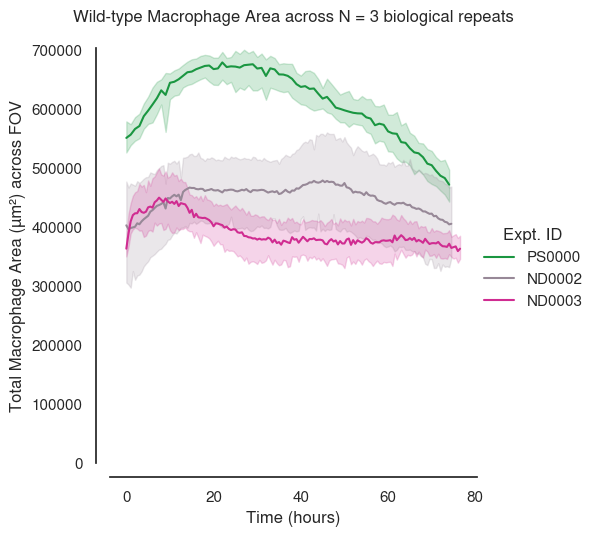

In [81]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Strain'] == 'WT') 
            & (df['Compound'] == 'CTRL')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Macrophage Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    # style = 'Acq. ID',
    palette = colors
)

plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Total Macrophage Area (µm²) across FOV')
plt.title('Wild-type Macrophage Area across N = 3 biological repeats\n')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Macrophage strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_macrophage_growth_WT.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


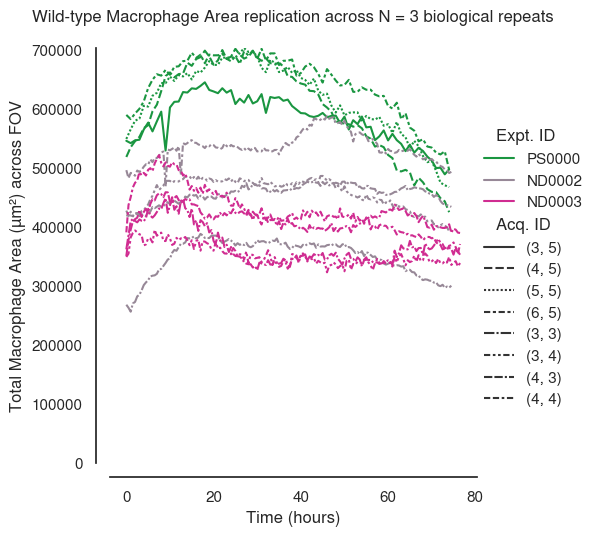

In [82]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Strain'] == 'WT') 
             & (df['Compound'] == 'CTRL')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Macrophage Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    style = 'Acq. ID',
    palette = colors
)
plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Total Macrophage Area (µm²) across FOV')
plt.title('Wild-type Macrophage Area replication across N = 3 biological repeats\n')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_macrophage_growth_positions.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


## RD1 - needs fixing for ND3.5.3

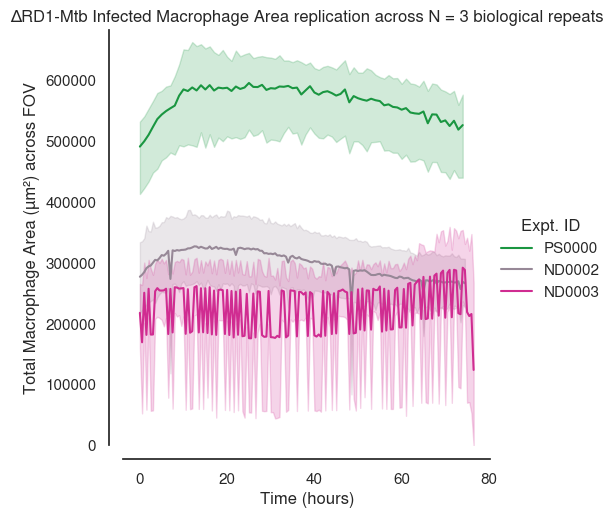

In [85]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Strain'] == 'RD1') 
             & (df['Compound'] == 'CTRL')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Macrophage Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID',
    palette = colors
)

plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())
plt.ylabel('Total Macrophage Area (µm²) across FOV')
sns.despine(offset=10)
plt.xlabel('Time (hours)')
plt.title('ΔRD1-Mtb Infected Macrophage Area replication across N = 3 biological repeats')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_macrophage_growth_RD1.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


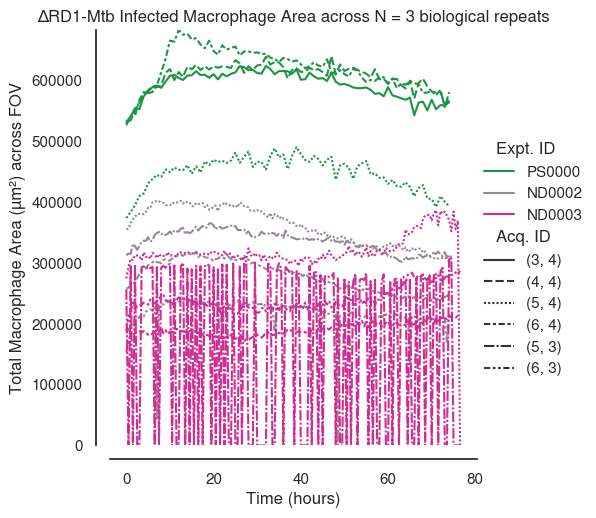

In [86]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Strain'] == 'RD1') 
             & (df['Compound'] == 'CTRL')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Macrophage Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    style = 'Acq. ID',
    palette = colors
)

sns.despine(offset=10)
plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())
plt.ylabel('Total Macrophage Area (µm²) across FOV')
plt.xlabel('Time (hours)')
plt.title('ΔRD1-Mtb Infected Macrophage Area across N = 3 biological repeats')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_macrophage_growth_RD1_positions.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


## WT and RD1

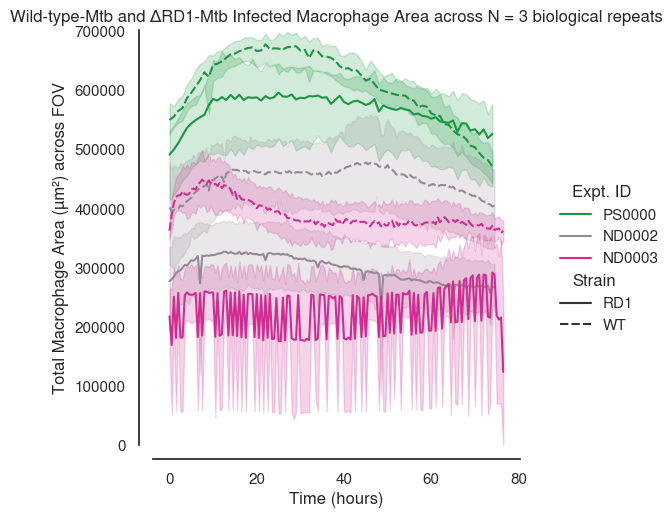

In [88]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Compound'] == 'CTRL') & (df['Strain'] != 'UNI')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Macrophage Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    # style = 'Acq. ID',
    style='Strain',
    palette = colors
)

sns.despine(offset=10)
plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())
plt.ylabel('Total Macrophage Area (µm²) across FOV')
plt.xlabel('Time (hours)')
plt.title('Wild-type-Mtb and ΔRD1-Mtb Infected Macrophage Area across N = 3 biological repeats')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_macrophage_growth_WT_RD1.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


### Uninf

/tmp/ipykernel_808522/1792496622.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


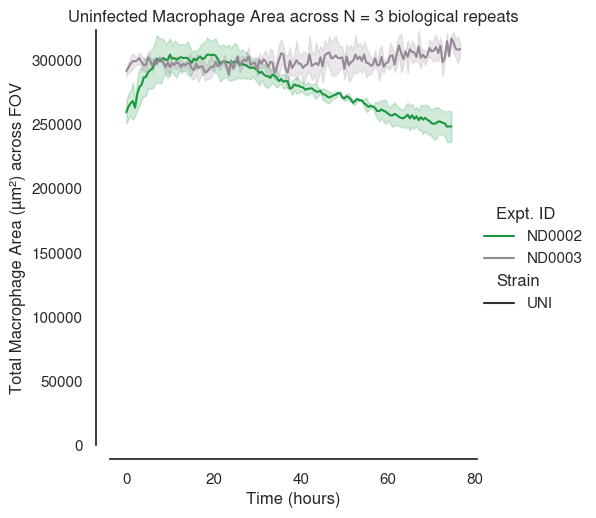

In [92]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Compound'] == 'CTRL') & (df['Strain'] == 'UNI')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Macrophage Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    # style = 'Acq. ID',
    style='Strain',
    palette = colors
)

sns.despine(offset=10)
plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())
plt.ylabel('Total Macrophage Area (µm²) across FOV')
plt.xlabel('Time (hours)')
plt.title('Uninfected Macrophage Area across N = 3 biological repeats')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_macrophage_growth_unif.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


## Comparing Atbs

#### Add repeat number to assay layout

### mapping colours to previous

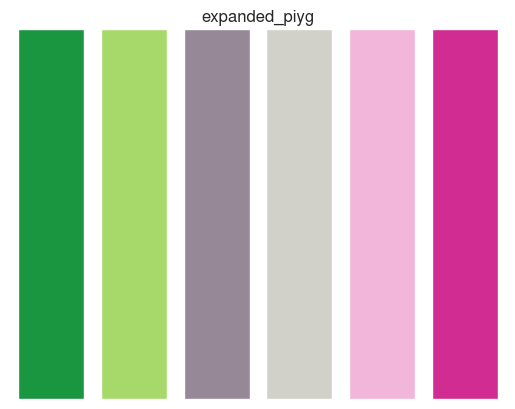

[(0, '#1a9641'),
 (1, '#a6d96a'),
 (2, '#978897'),
 (3, '#d1d1ca'),
 (4, '#f1b6da'),
 (5, '#d02c91')]

In [93]:
### mapping colours to be teh same as last time
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg')
[(n, i) for n, i in enumerate(colours.expanded_piyg)]

In [94]:
colour_map_dict = {'RD1':colours.expanded_piyg[0], 
                   'WT': colours.expanded_piyg[1], 
                   'PZA': colours.expanded_piyg[2], 
                   'RIF': colours.expanded_piyg[3], 
                   'INH': colours.expanded_piyg[4], 
                   'BDQ': colours.expanded_piyg[5], 
                   'UNI': '#000000'}

### Plot different atb conditions per repeat

In [95]:
df['Compound'].unique()

array(['CTRL', 'PZA', 'RIF', 'INH', 'BDQ'], dtype=object)

  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

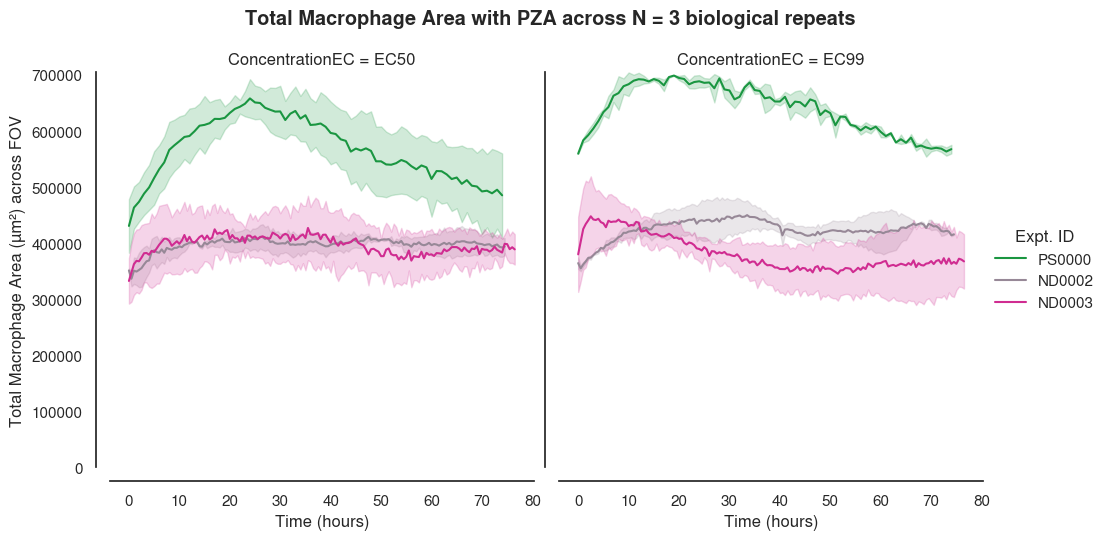

<Figure size 640x480 with 0 Axes>

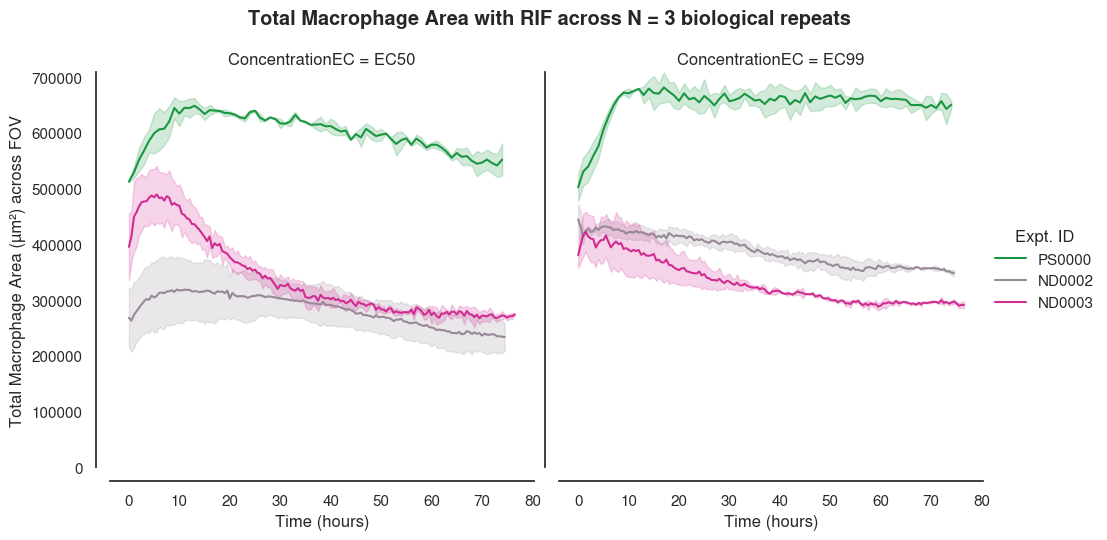

<Figure size 640x480 with 0 Axes>

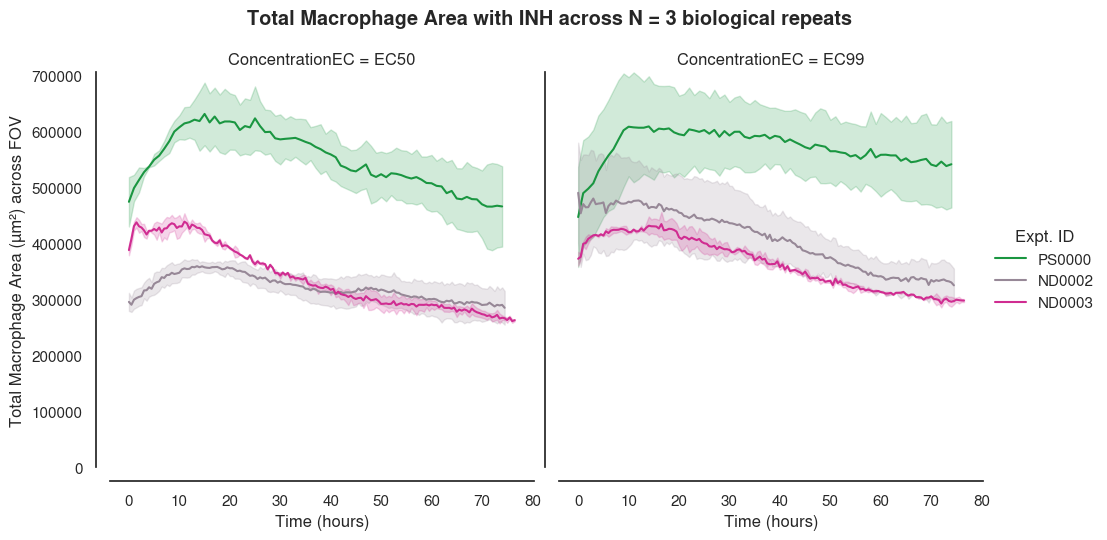

<Figure size 640x480 with 0 Axes>

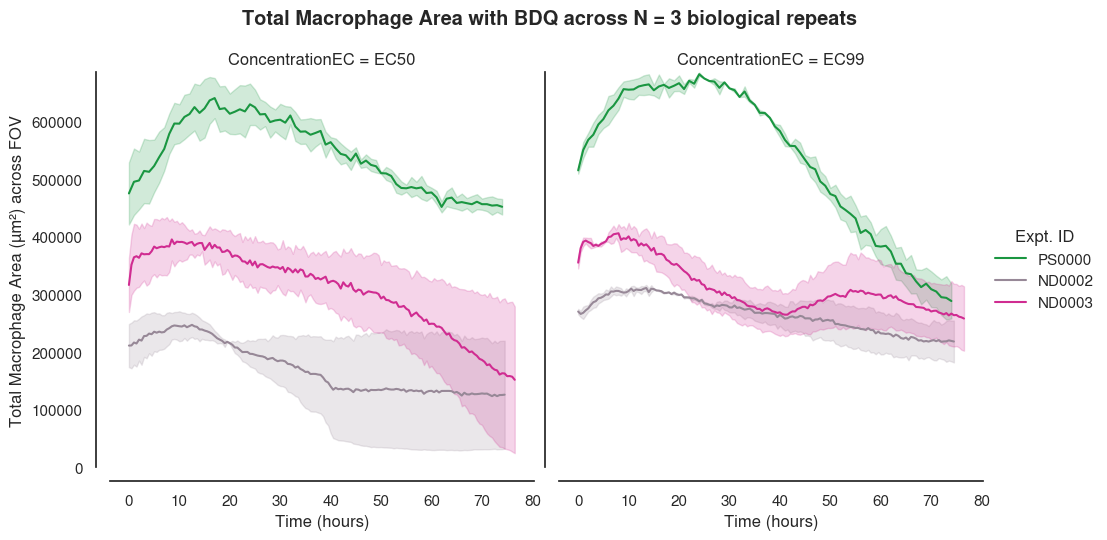

In [96]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'WT')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Macrophage Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        # style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Macrophage Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())

    plt.suptitle(f'Total Macrophage Area with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_WT_{compound}.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

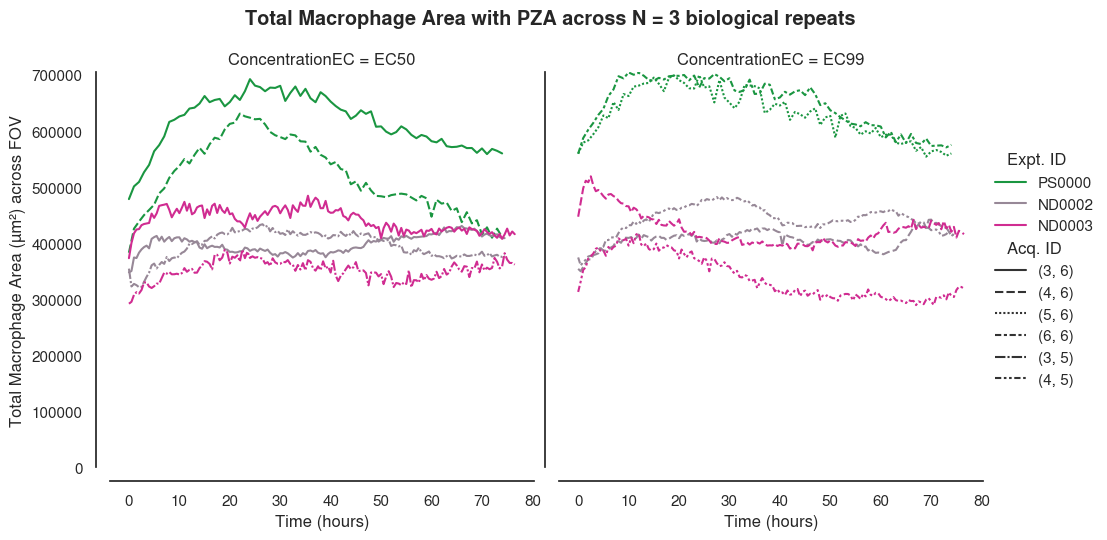

<Figure size 640x480 with 0 Axes>

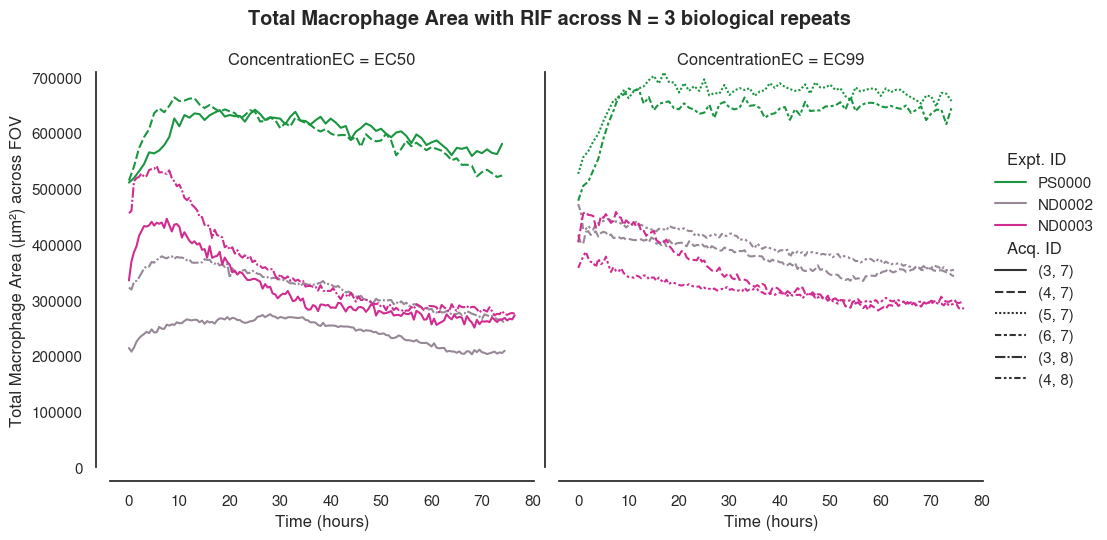

<Figure size 640x480 with 0 Axes>

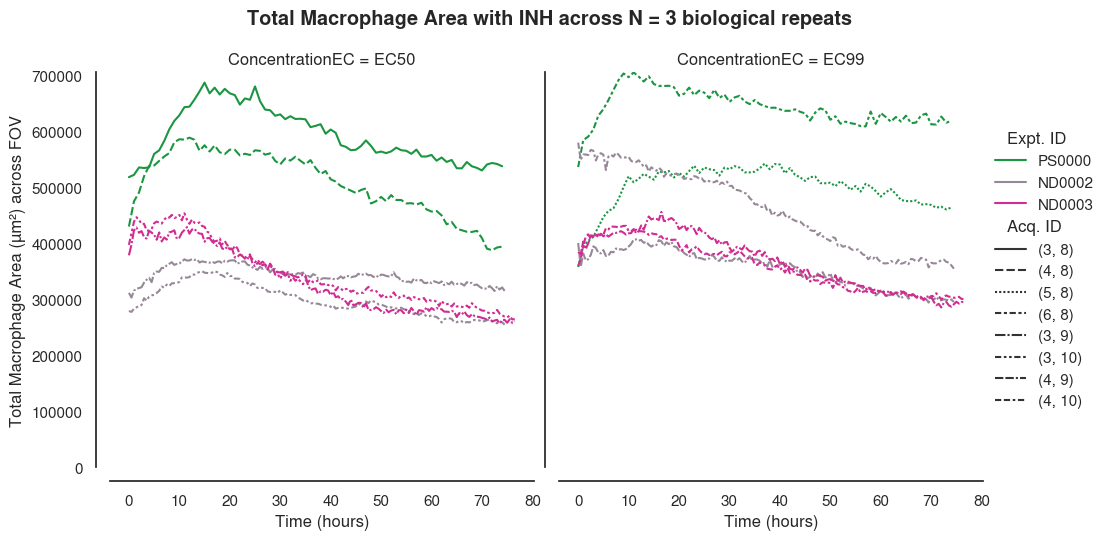

<Figure size 640x480 with 0 Axes>

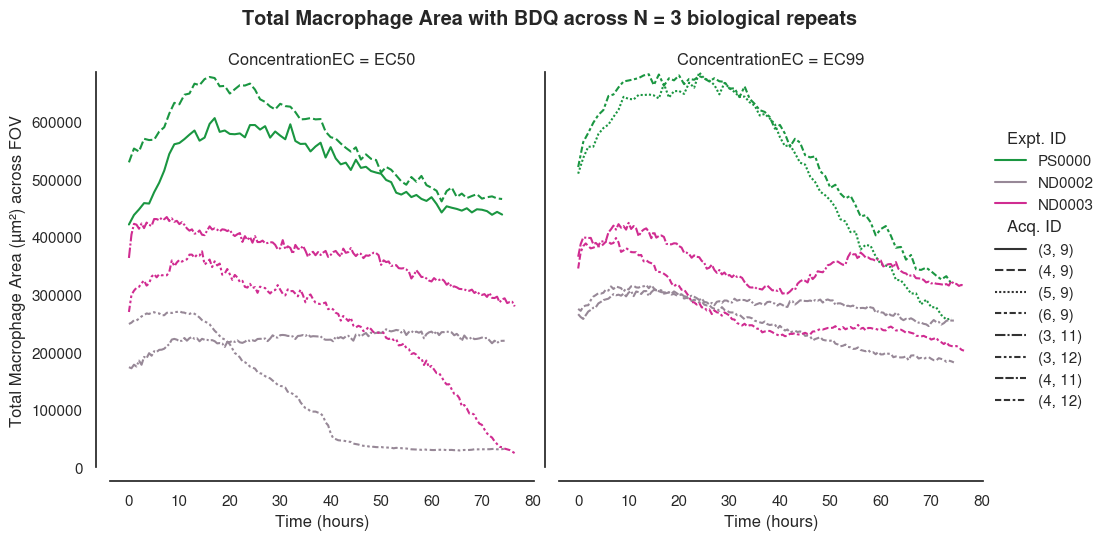

In [97]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'WT')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Macrophage Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Macrophage Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())

    plt.suptitle(f'Total Macrophage Area with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_WT_{compound}_positions.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


# RD1

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_808522/32541994.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

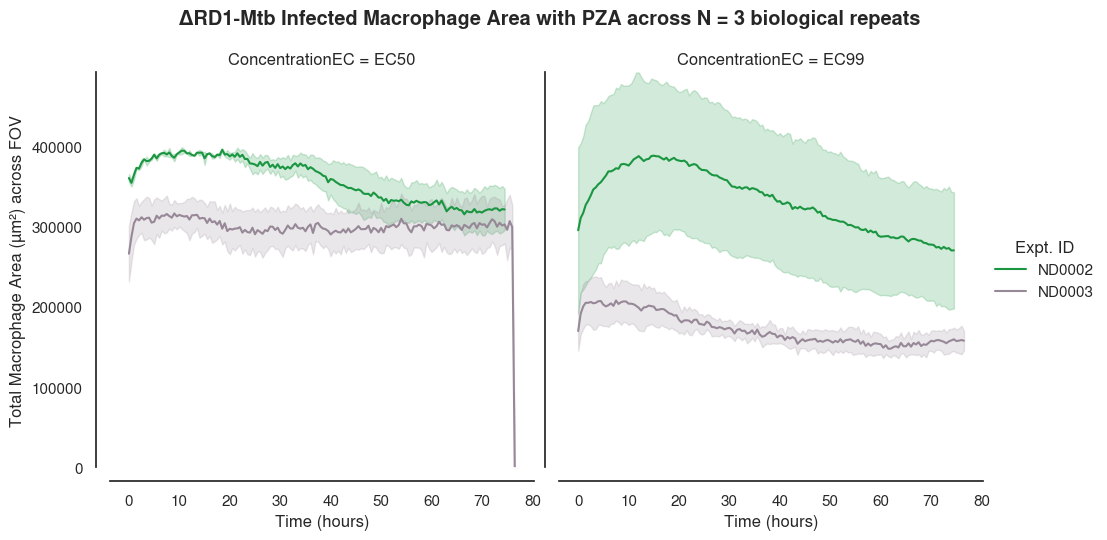

/tmp/ipykernel_808522/32541994.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

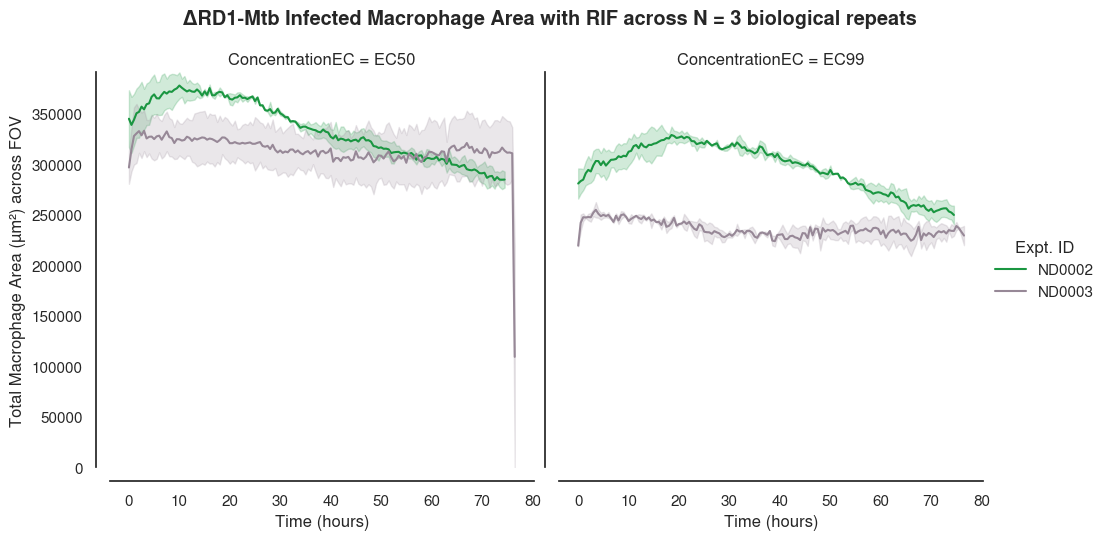

/tmp/ipykernel_808522/32541994.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

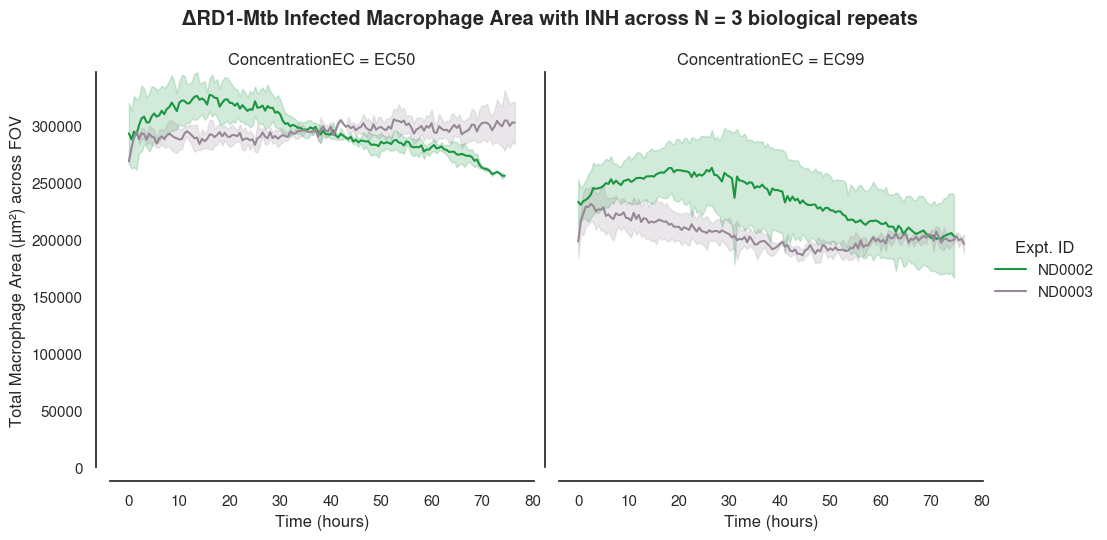

/tmp/ipykernel_808522/32541994.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

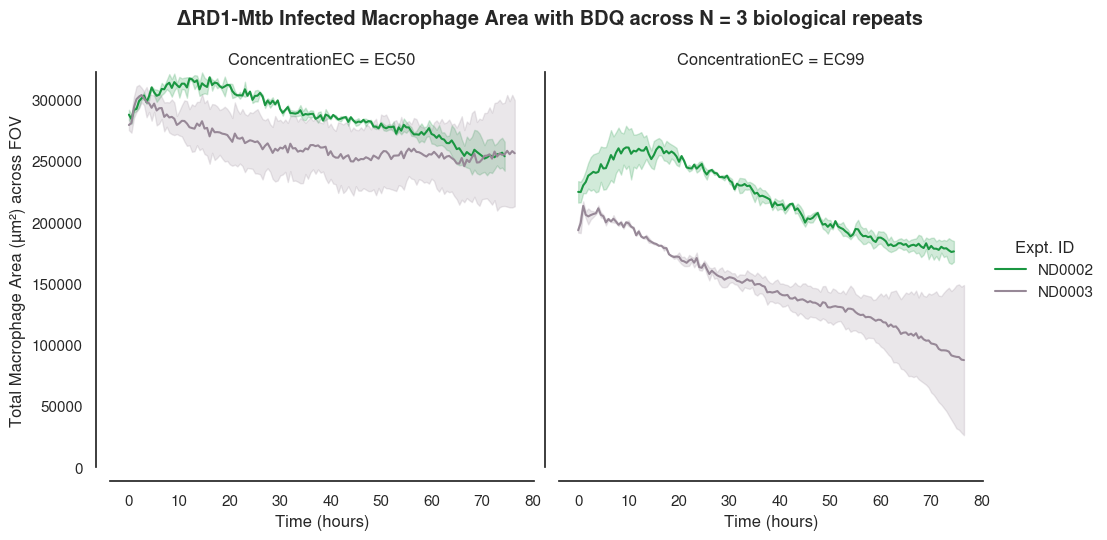

In [99]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'RD1')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Macrophage Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        # style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Macrophage Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())

    plt.suptitle(f'ΔRD1-Mtb Infected Macrophage Area with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_RD1_{compound}.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_808522/426704240.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

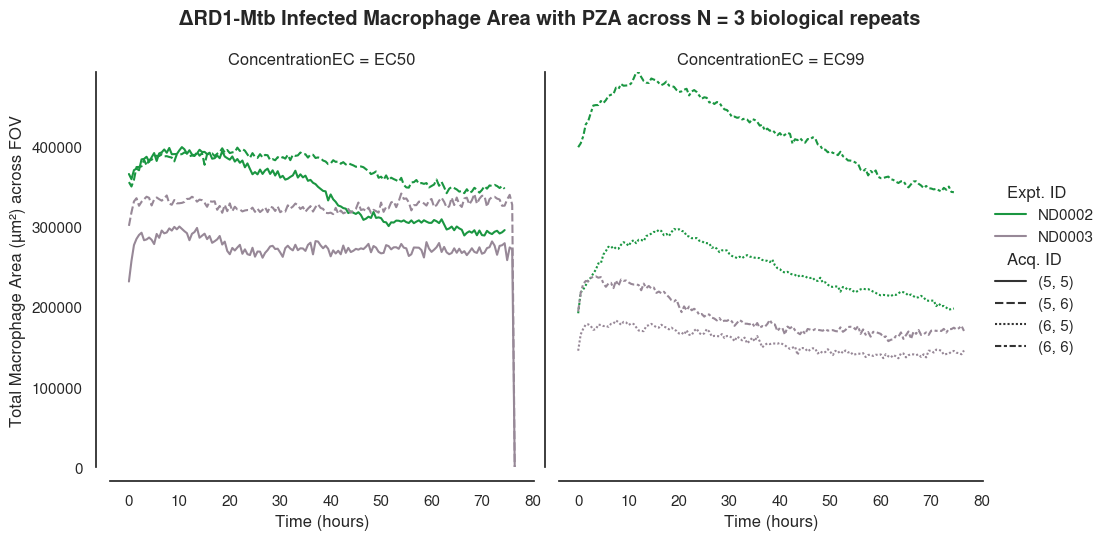

/tmp/ipykernel_808522/426704240.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

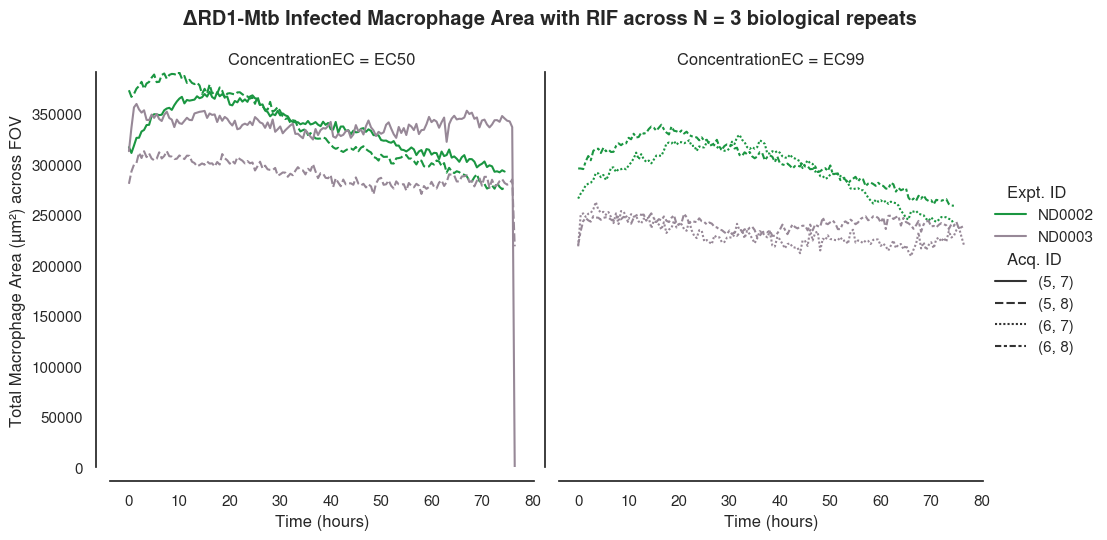

/tmp/ipykernel_808522/426704240.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

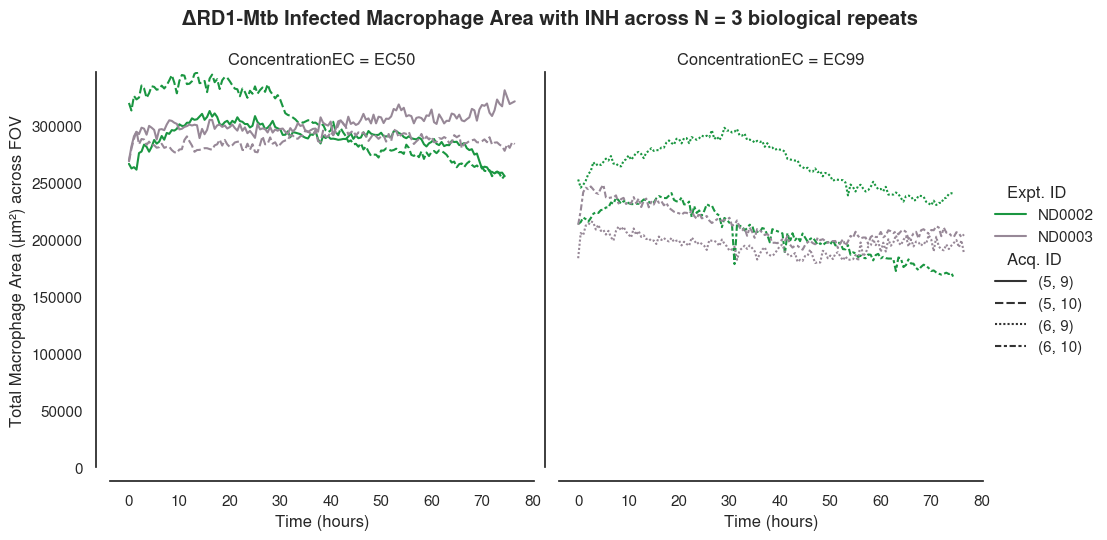

/tmp/ipykernel_808522/426704240.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

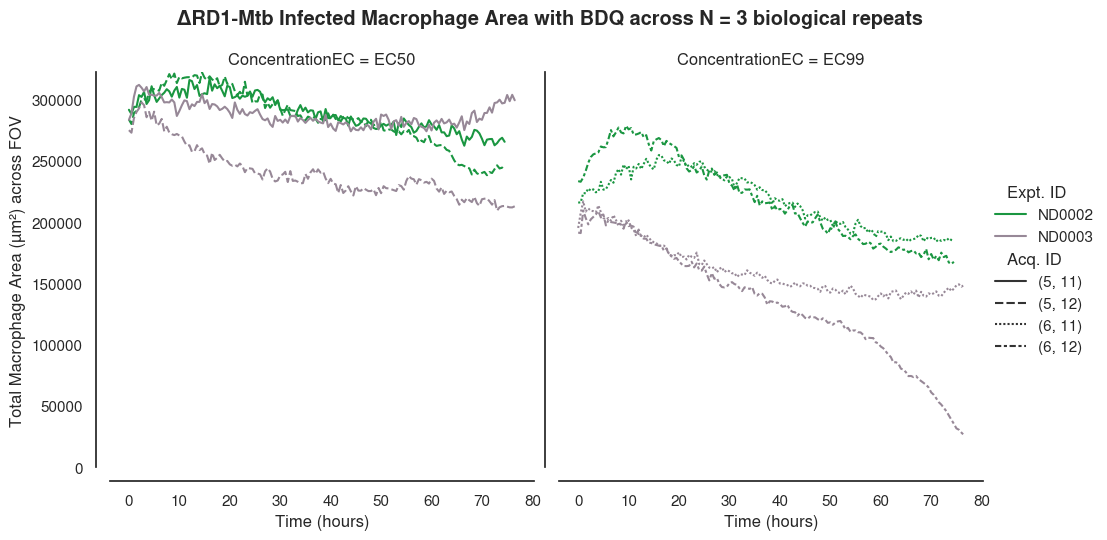

In [100]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'RD1')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Macrophage Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Macrophage Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Macrophage Area (µm)'].max())

    plt.suptitle(f'ΔRD1-Mtb Infected Macrophage Area with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_RD1_{compound}_positions.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


### Plot different atb conditions per repeat

/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


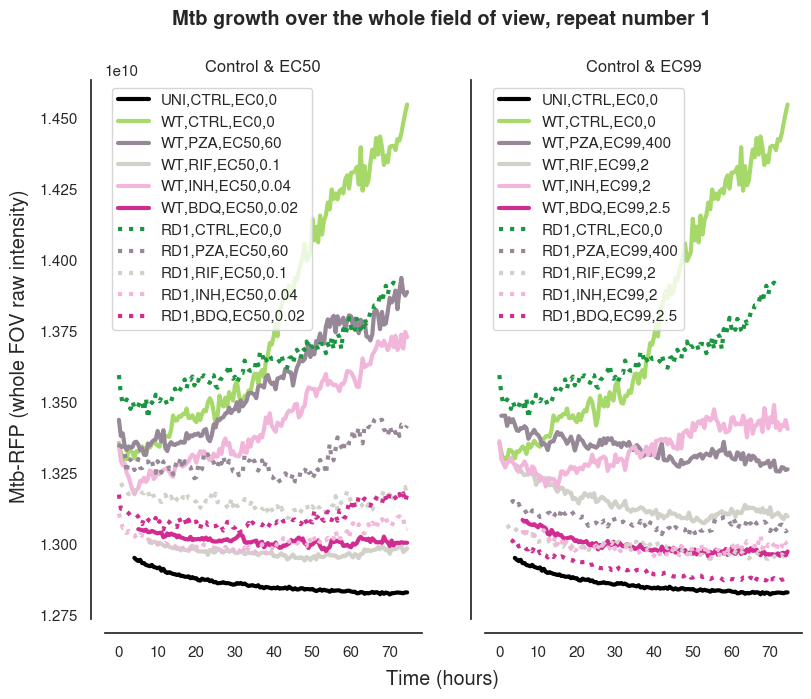

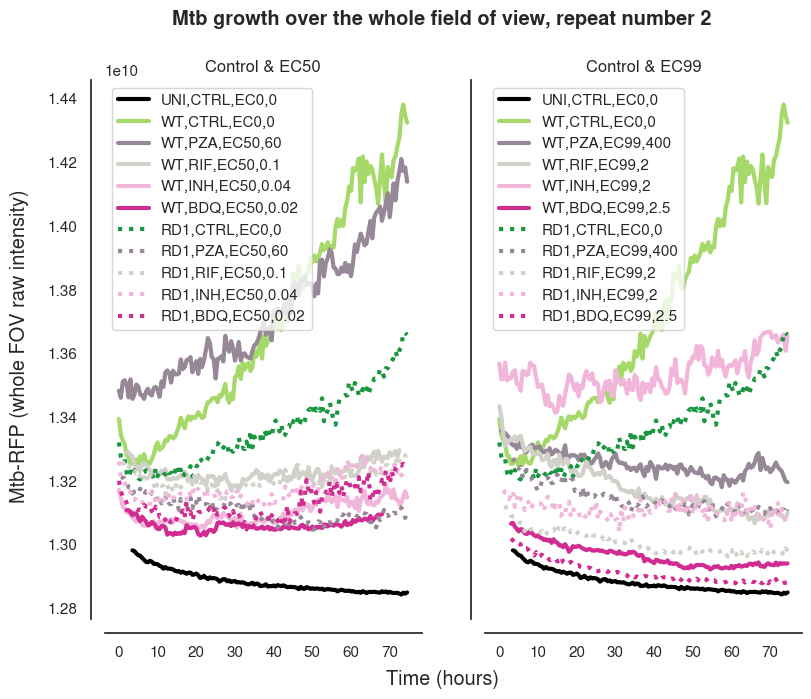

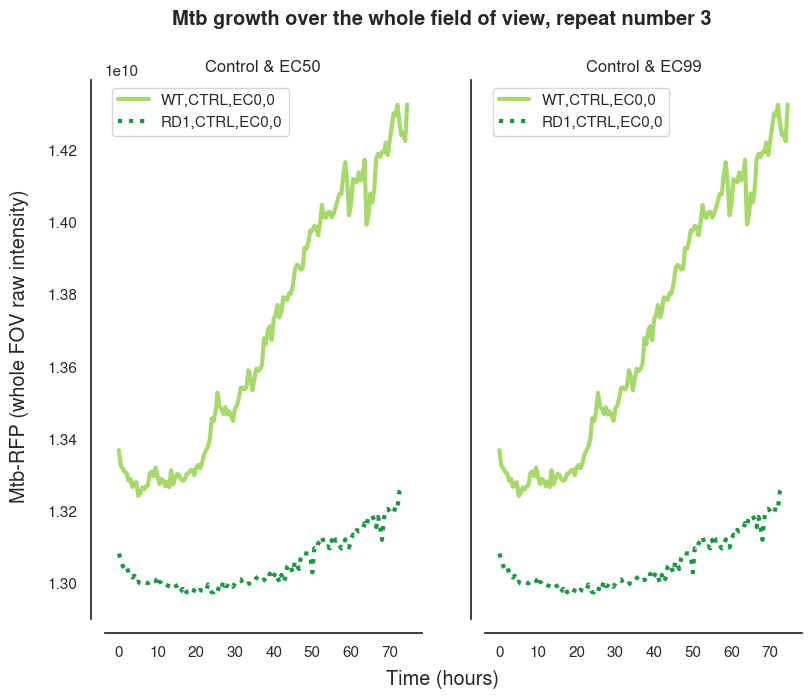

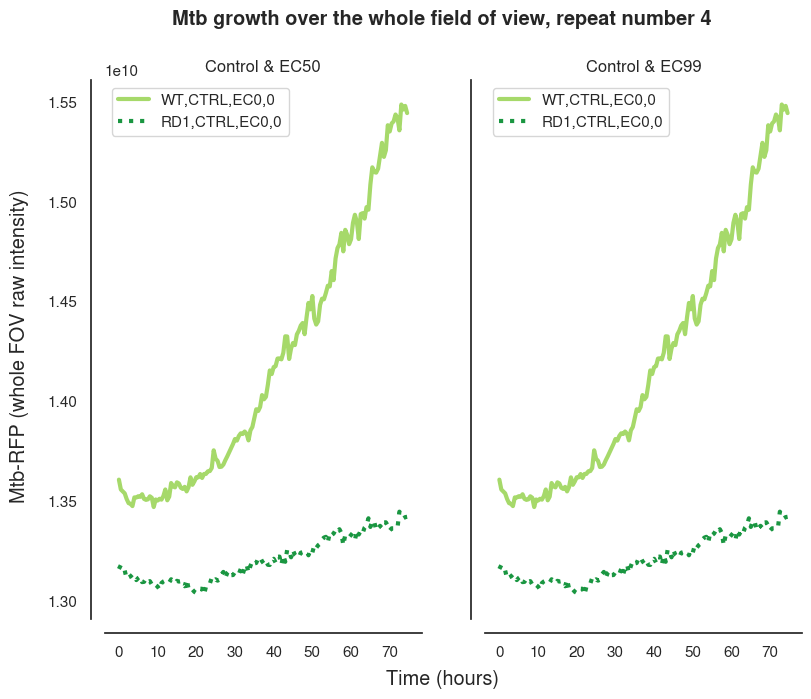

In [422]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wRD1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


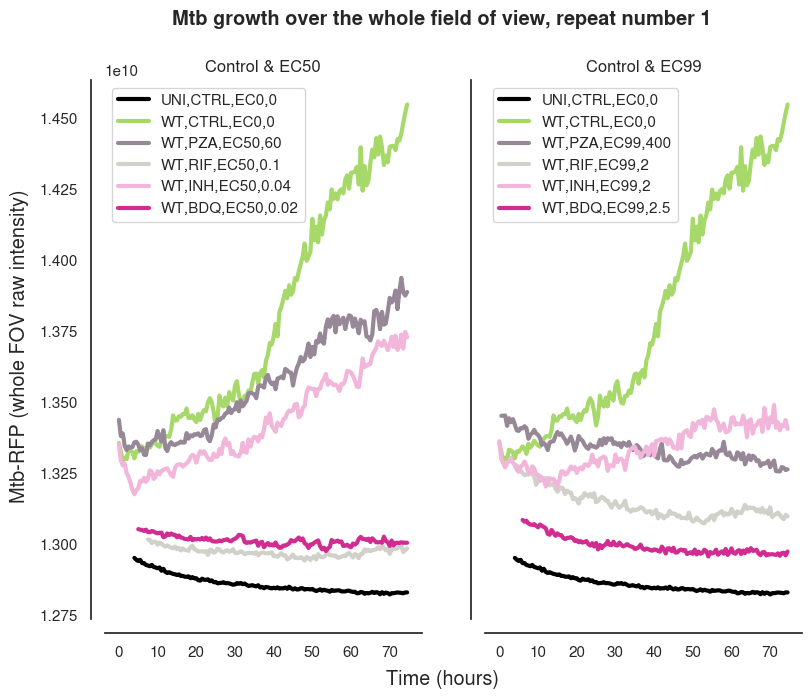

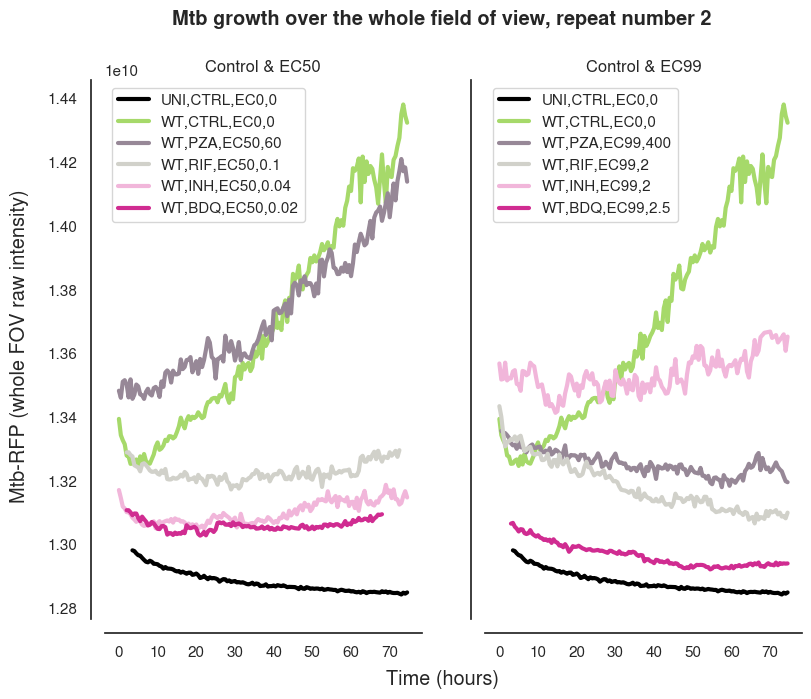

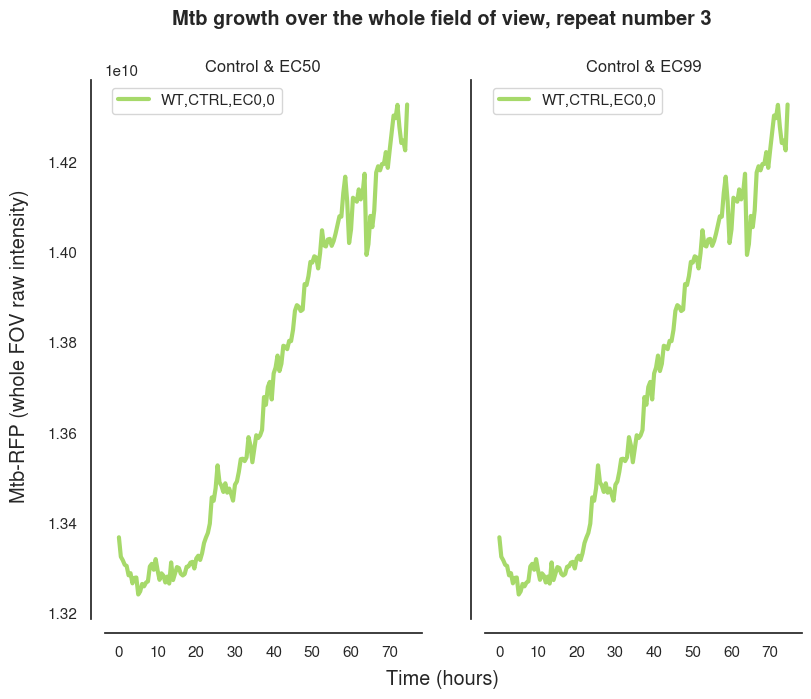

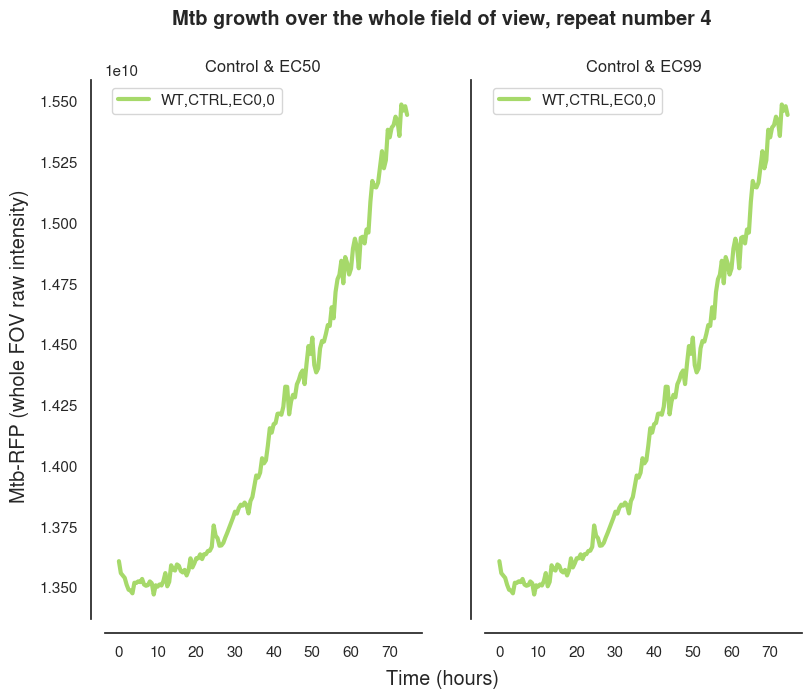

In [423]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


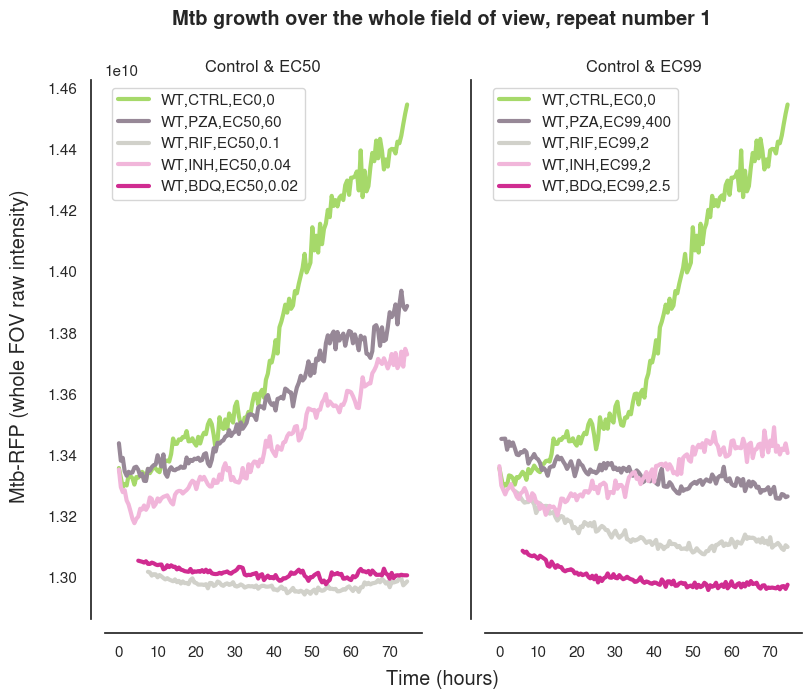

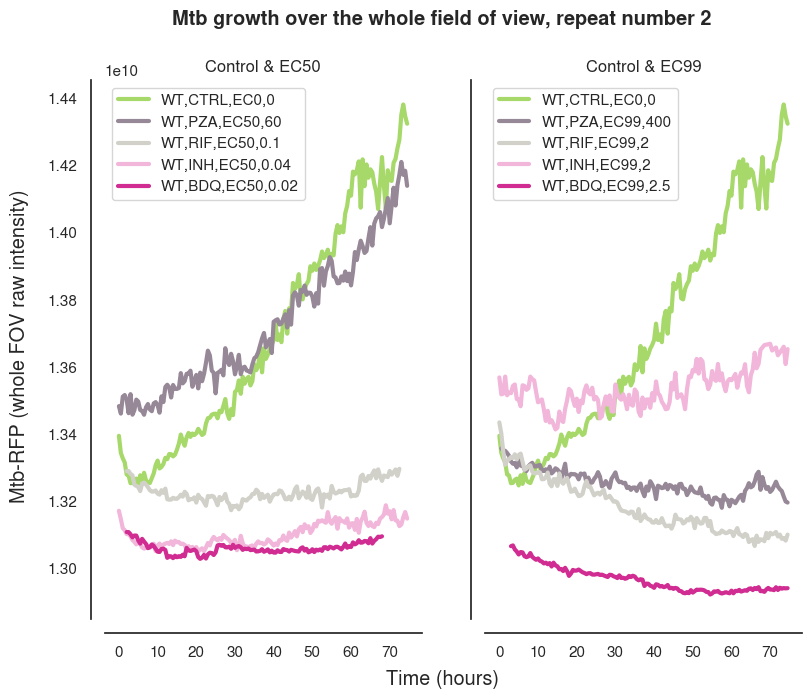

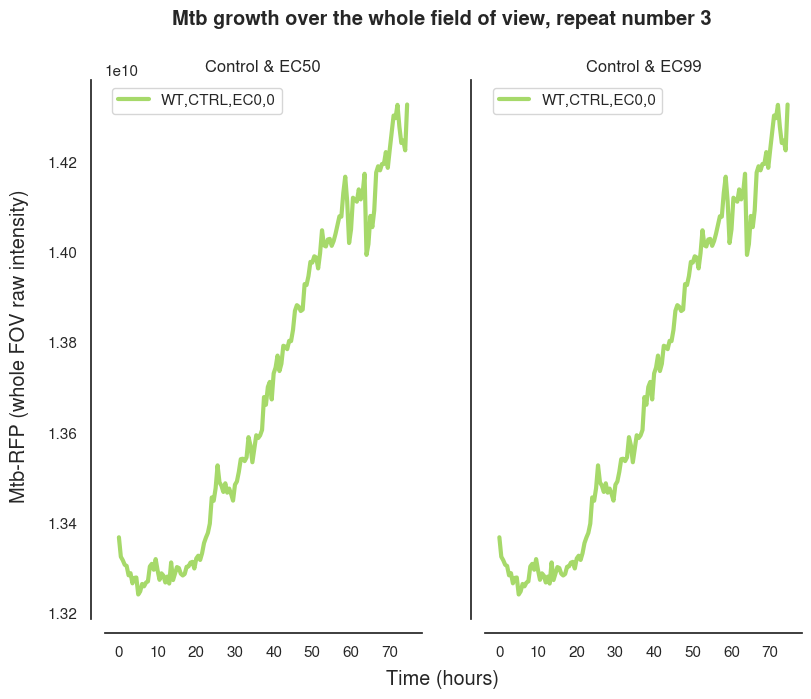

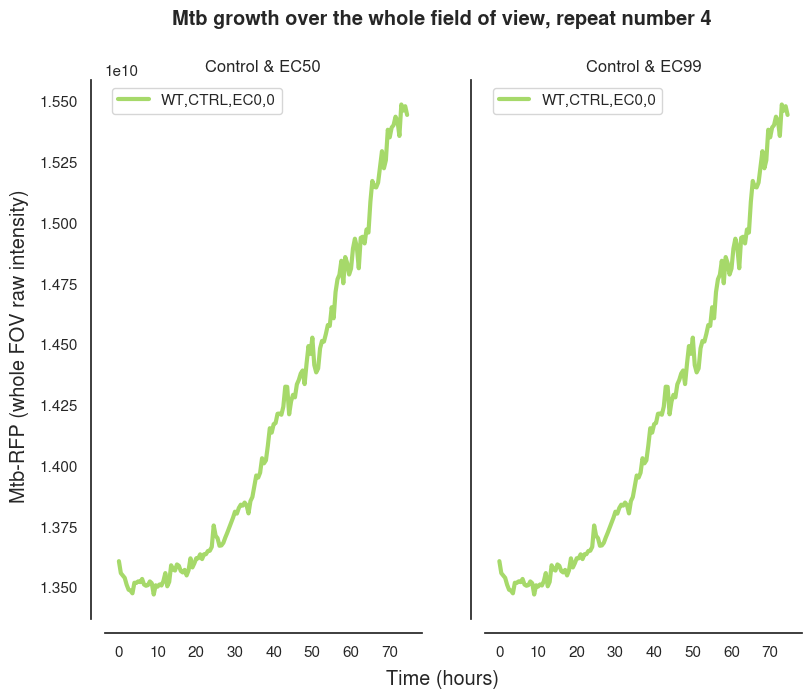

In [424]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_word1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


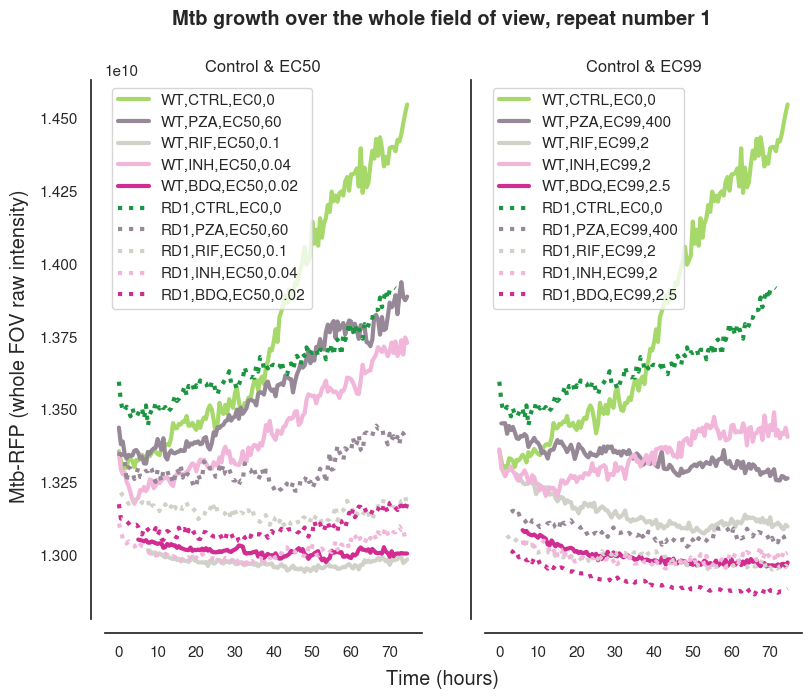

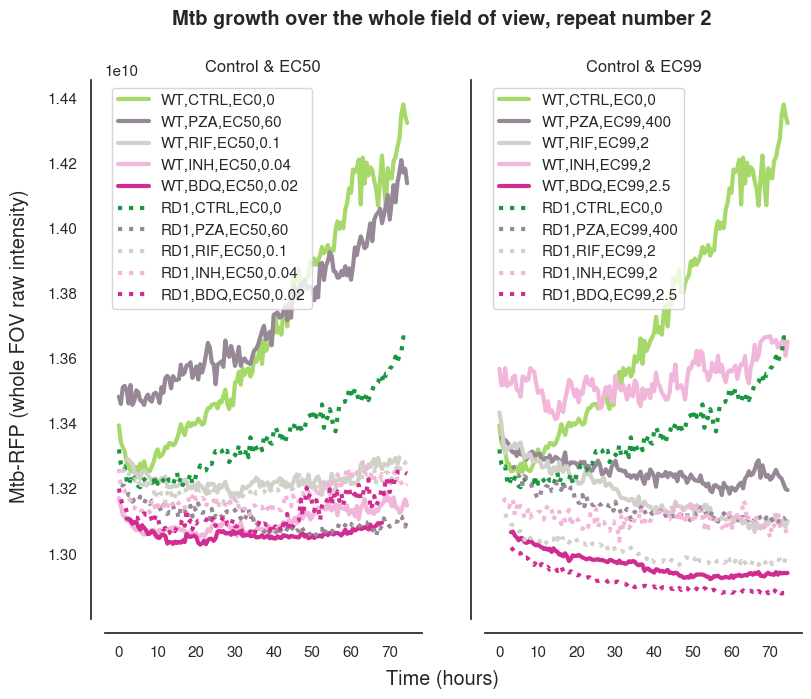

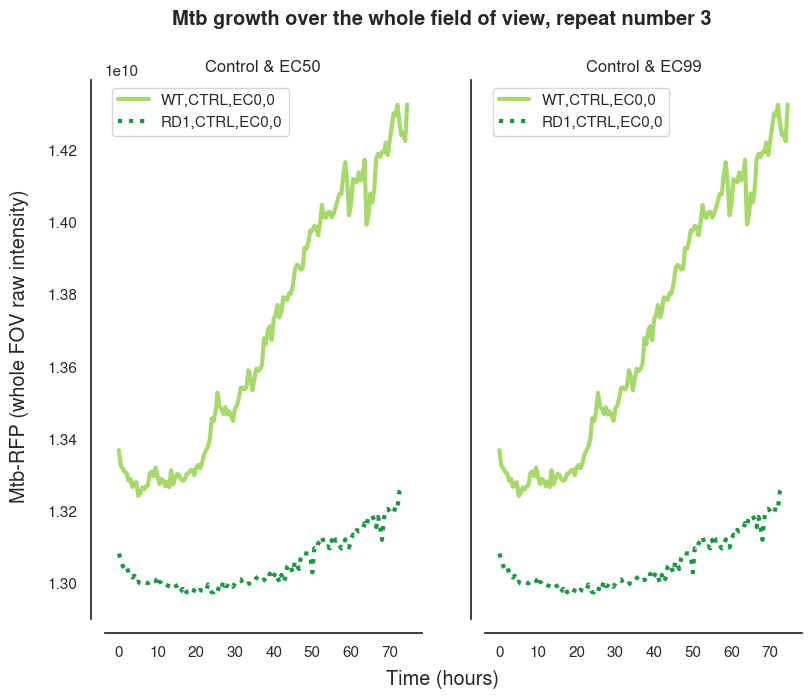

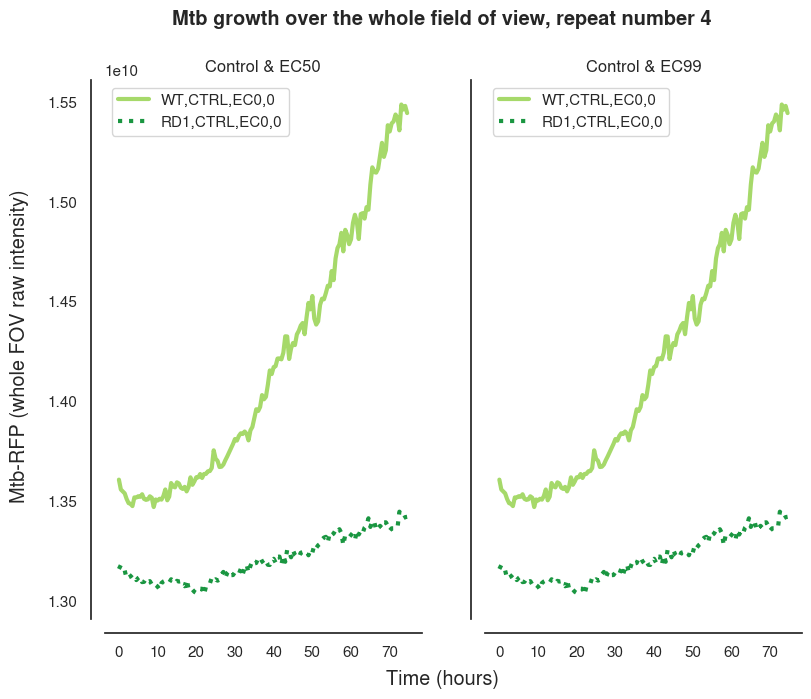

In [425]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



### Plotting repeats overlaid

In [450]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [449]:
assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates()

Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
4   5          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
6   5         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99

In [451]:
for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    print(info)


Strain              UNI
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 1), dtype: object
Strain               WT
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 3), dtype: object
Strain               WT
Compound            PZA
Concentration        60
ConcentrationEC    EC50
Name: (3, 5), dtype: object
Strain               WT
Compound            RIF
Concentration       0.1
ConcentrationEC    EC50
Name: (3, 7), dtype: object
Strain               WT
Compound            INH
Concentration      0.04
ConcentrationEC    EC50
Name: (3, 9), dtype: object
Strain               WT
Compound            BDQ
Concentration      0.02
ConcentrationEC    EC50
Name: (3, 11), dtype: object
Strain               WT
Compound            PZA
Concentration       400
ConcentrationEC    EC99
Name: (4, 5), dtype: object
Strain               WT
Compound            RIF
Concentration         2
ConcentrationEC    EC99
Name: (4, 7), dtype: object
Strain 

In [453]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [473]:
cleaned_series

0             1             2             3    \
Row Column                                                           
6   11      1.310772e+10  1.308648e+10  1.307119e+10  1.305876e+10   
    12      1.311994e+10  1.309136e+10  1.305267e+10  1.304545e+10   

                     4             5             6             7    \
Row Column                                                           
6   11      1.304037e+10  1.304033e+10  1.301729e+10  1.301309e+10   
    12      1.304272e+10  1.302610e+10  1.301955e+10  1.301408e+10   

                     8             9    ...           140           141  \
Row Column                              ...                               
6   11      1.299978e+10  1.300731e+10  ...  1.287938e+10  1.287871e+10   
    12      1.300614e+10  1.300051e+10  ...  1.288578e+10  1.287866e+10   

                     142           143           144           145  \
Row Column                                                           
6   11      1.288302e+10  1.287753e+10  1.287248e+10  1.287729e+10   
    12      1.288287e+10  1.289255e+10  1.288116e+10  1.288207e+10   

                     146           147           148           149  
Row Column                                                          
6   11      1.287703e+10  1.287929e+10  1.288263e+10  1.288682e+10  
    12      1.287799e+10  1.288075e+10  1.288131e+10  1.288176e+10  

[2 rows x 150 columns]

In [470]:
assay_layout['Technical repeat'].unique()

array([1, 2, 3, 4])

In [484]:
concat_series

8      1.295410e+10
9      1.294740e+10
10     1.294297e+10
11     1.294719e+10
12     1.293553e+10
           ...     
145    1.284703e+10
146    1.284426e+10
147    1.284991e+10
148    1.284697e+10
149    1.285080e+10
Length: 285, dtype: float64

/tmp/ipykernel_1217616/2323974640.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


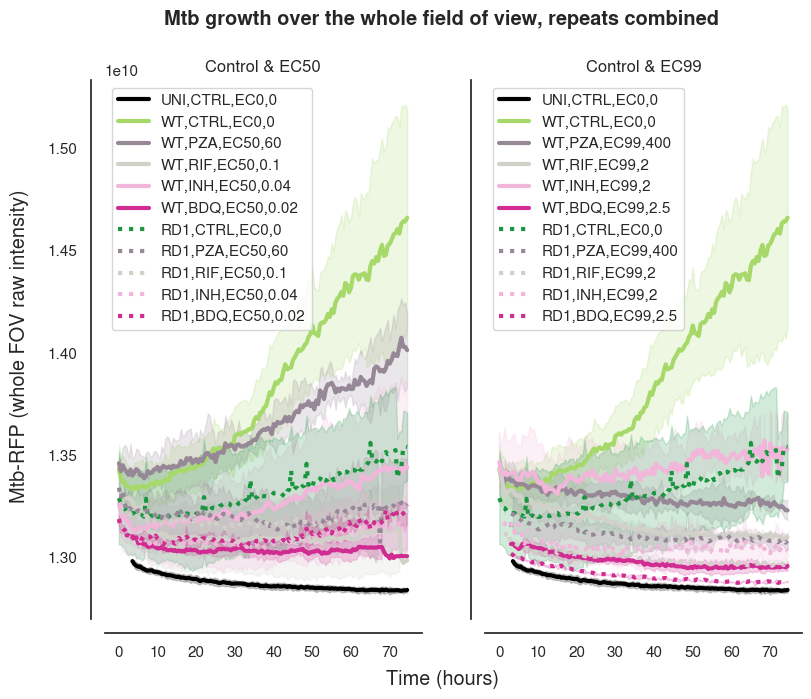

In [498]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3755018027.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


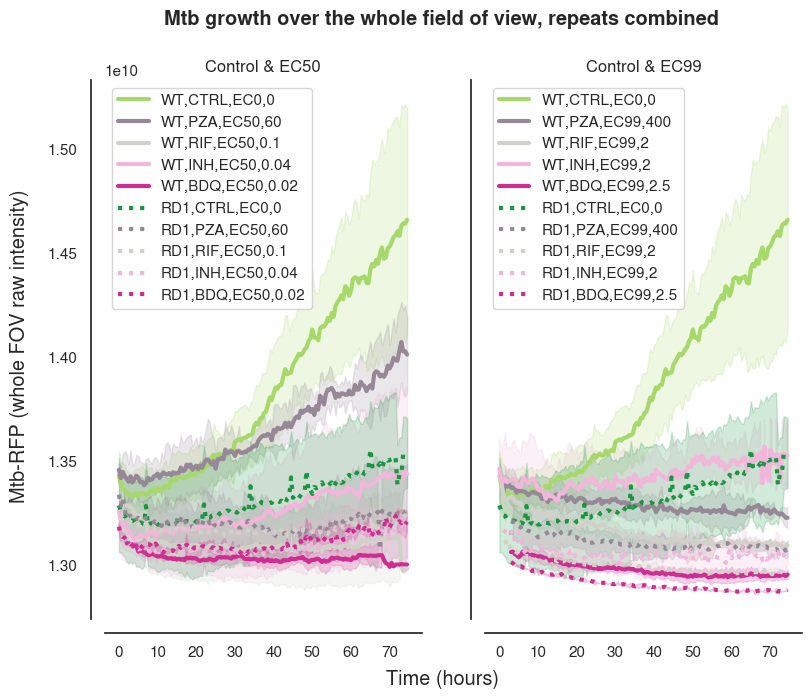

In [499]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3533890359.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


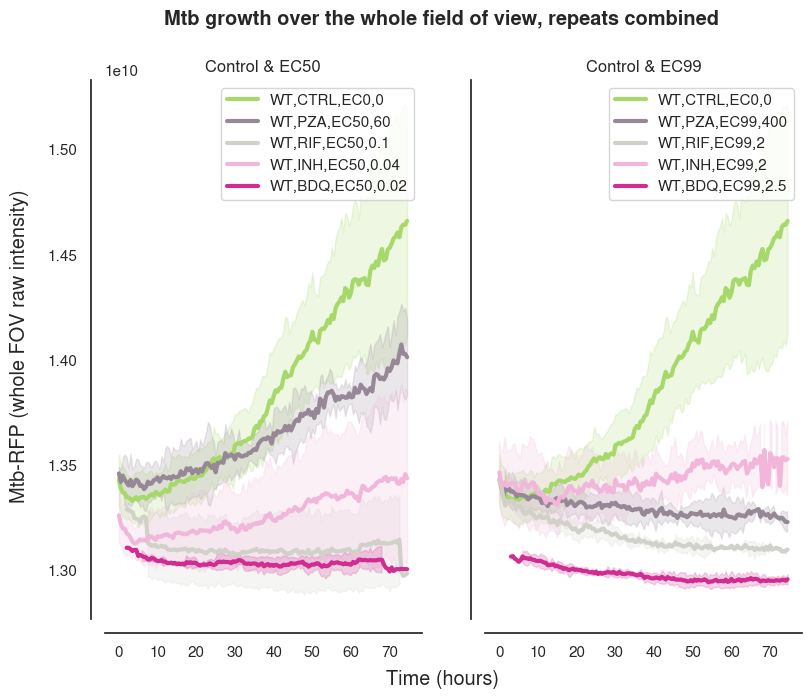

In [500]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI', 'RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/235941939.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


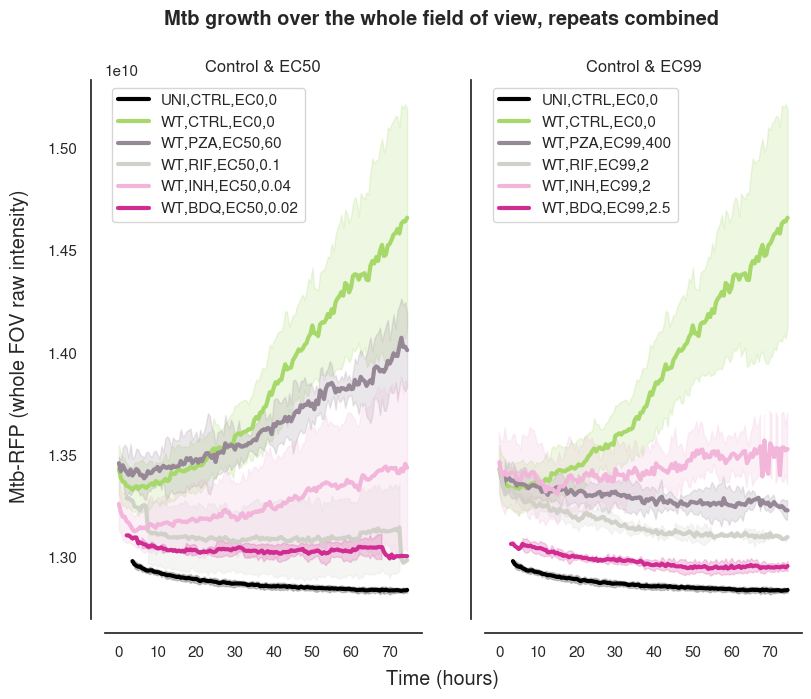

In [501]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()

